In [230]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow as tf
from pix2vid2 import make_model
from utils import check_tf_gpu, describe_data

NUM_REALIZATIONS = 929
NX,  NY,  NZ = 64, 64, 1
NTT, NT1, NT2 = 40, 20, 5
HIDDEN = [16, 64, 256]

folder     = 'SlopingAquiferSmall'
sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6
check_tf_gpu()

--------------------------------------------------------------
------------------------ VERSION INFO ------------------------
TF version: 2.15.0 | Keras: 3.5.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
--------------------------------------------------------------



In [2]:
deltatime = sio.loadmat('{}/simulations/data/time_arr.mat'.format(folder), simplify_cells=True)['time_arr']
timesteps = np.cumsum(deltatime)
timesteps_inj = timesteps[:20]
timesteps_mon = timesteps[[21, 24, 29, 34, 39]]

print('timesteps: {} | deltatime: {}'.format(len(timesteps), np.unique(deltatime)))
print('injection: {}'.format(timesteps_inj))
print('monitoring: {}'.format(timesteps_mon))

timesteps: 40 | deltatime: [ 0.5 50. ]
injection: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
monitoring: [ 110.  260.  510.  760. 1010.]


In [3]:
# Load data
X_data = np.load('{}/simulations/data/X_data.npy'.format(folder))
c_data = np.load('{}/simulations/data/c_data.npy'.format(folder))
y1_data = np.load('{}/simulations/data/y1_data.npy'.format(folder))
y2_data = np.load('{}/simulations/data/y2_data.npy'.format(folder))[:,[1, 4, 9, 14, 19]]

# Normalize data
pmu, psd = X_data[...,0].mean(), X_data[...,0].std() # porosity
kmu, ksd = X_data[...,1].mean(), X_data[...,1].std() # permeability
wmi, wma = X_data[...,2].min(),  X_data[...,2].max() # wells
tmi, tma = X_data[...,3].min(),  X_data[...,3].max() # tops
vmi, vma = X_data[...,4].min(),  X_data[...,4].max() # volumes
cmi, cma = c_data.min(),         c_data.max()        # controls

X_data[...,0] = (X_data[...,0] - pmu) / (3.33*psd)
X_data[...,1] = (X_data[...,1] - kmu) / (3.33*ksd)
X_data[...,2] = (X_data[...,2] - wmi) / (wma - wmi)
X_data[...,3] = (X_data[...,3] - tmi) / (tma - tmi)
X_data[...,4] = (X_data[...,4] - vmi) / (vma - vmi)
c_data = c_data / 2.0

y1_data[...,0]  = y1_data[...,0]  / 50e3
y1_data[...,-1] = y1_data[...,-1] / 0.73
y2_data[...,-1] = y2_data[...,-1] / 0.73

describe_data(X_data, c_data, y1_data, y2_data)

X: (929, 64, 64, 5) | c: (929, 20, 5)
y1: (929, 20, 64, 64, 2) | y2: (929, 5, 64, 64, 1)
porosity     - min: -0.62 | max: 2.35
logperm      - min: -2.19 | max: 2.48
wells        - min: 0.00 | max: 1.00
tops         - min: 0.00 | max: 1.00
volumes      - min: 0.00 | max: 1.00
controls     - min: 0.00 | max: 0.83
pressure_1   - min: 0.08 | max: 0.91
saturation_1 - min: 0.00 | max: 0.93
saturation_2 - min: 0.00 | max: 0.93


In [4]:
train_idx = np.load('{}/models/training_idx.npy'.format(folder))
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

X_train = X_data[train_idx].astype(np.float32)
c_train = c_data[train_idx].astype(np.float32)
y1_train = y1_data[train_idx].astype(np.float32)
y2_train = y2_data[train_idx].astype(np.float32)
X_test = X_data[test_idx].astype(np.float32)
c_test = c_data[test_idx].astype(np.float32)
y1_test = y1_data[test_idx].astype(np.float32)
y2_test = y2_data[test_idx].astype(np.float32)

print('X_train:  {}     | c_train: {}'.format(X_train.shape, c_train.shape))
print('y1_train: {} | y2_train: {}'.format(y1_train.shape, y2_train.shape))
print('-'*70)
print('X_test:  {}     | c_test: {}'.format(X_test.shape, c_test.shape))
print('y1_test: {} | y2_test: {}'.format(y1_test.shape, y2_test.shape))

X_train:  (800, 64, 64, 5)     | c_train: (800, 20, 5)
y1_train: (800, 20, 64, 64, 2) | y2_train: (800, 5, 64, 64, 1)
----------------------------------------------------------------------
X_test:  (129, 64, 64, 5)     | c_test: (129, 20, 5)
y1_test: (129, 20, 64, 64, 2) | y2_test: (129, 5, 64, 64, 1)


In [5]:
model = make_model(hidden=HIDDEN)
model.load_weights('{}/models/pix2vid-v2.weights.h5'.format(folder))

# parameters: 99,917,310


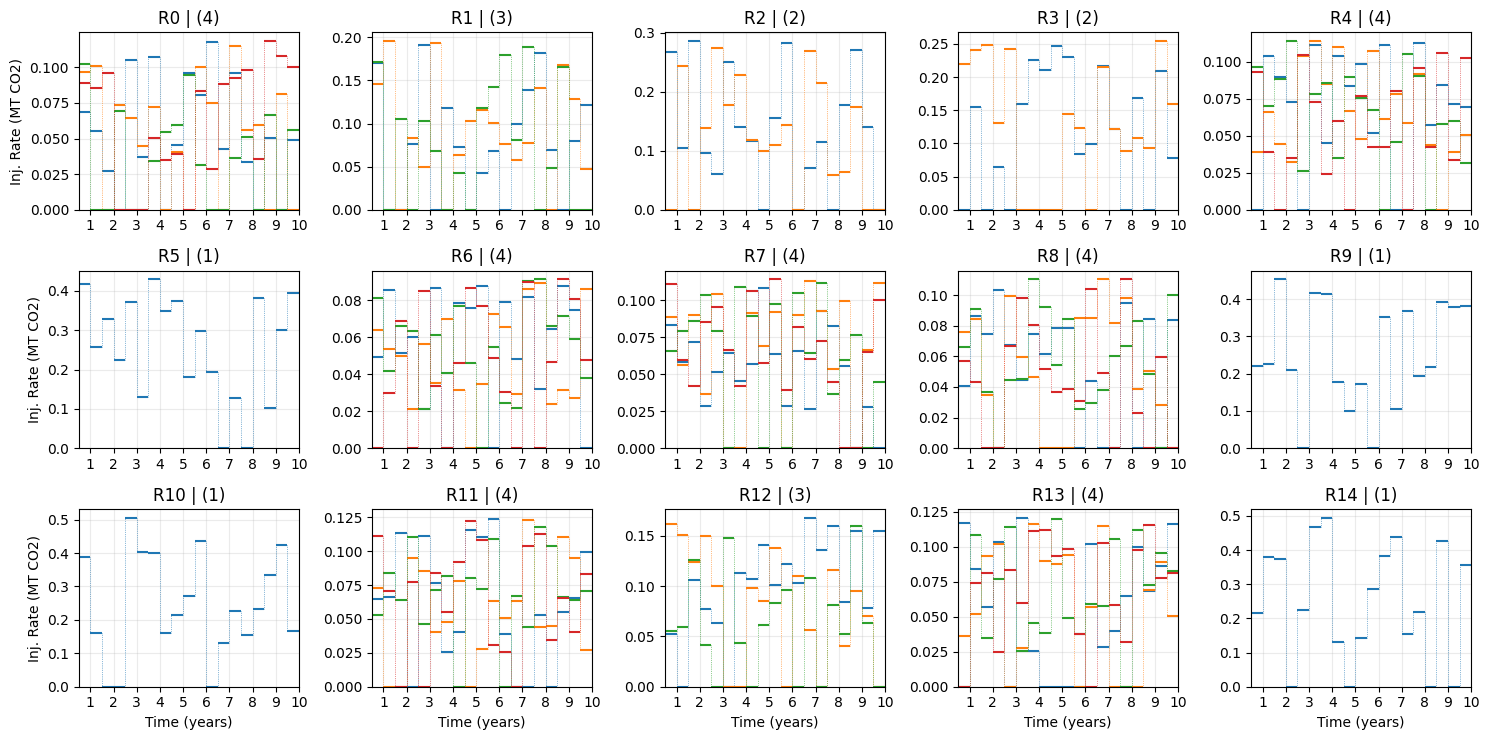

In [151]:
hues = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(15,7.5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    d = c_data[i]
    nw = len(np.unique(d.sum(0)))-1
    for w in range(nw):
        for t in range(len(timesteps_inj)-1):
            plt.hlines(d[t,w], timesteps_inj[t], timesteps_inj[t+1], color=hues[w])
            plt.vlines(timesteps_inj[t+1], d[t,w], d[t+1,w], color=hues[w], ls=':', lw=0.5)
    plt.title('R{} | ({})'.format(i, nw))
    plt.xlim(0.5,10)
    plt.ylim(0,None)
    plt.xticks(np.arange(1,11))
    plt.grid(True, which='both', alpha=0.25)
    plt.xlabel('Time (years)') if i > 9 else None
    plt.ylabel('Inj. Rate (MT CO2)') if i % 5 == 0 else None
plt.tight_layout()
plt.show()

***
### Optimization

In [242]:
porevol = np.load('{}/simulations/data/porevol.npy'.format(folder))
porevol.shape

(929, 64, 64)

5.0
10.229737


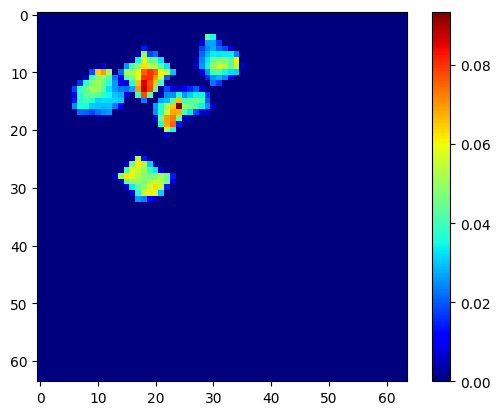

In [258]:
sample = 123

dc = c_train[sample].sum()
print(dc)

dd = (y2_train[sample, -1].squeeze() * porevol[sample]) / 1e3 / mega * co2_rho
print(np.sum(dd))

plt.imshow(dd, cmap='jet')
plt.colorbar()
plt.show()